# Bag of Words Model

**Dataset**: NYT dataset contains a **text** column consisting of news articles and a **label** column indicating the category to which this article belongs.

**Goal**: Train a text classifier using the following document representation techniques and report accuracy, macro-f1 score, and micro-f1 score on the test set.

* Each document is represented as a **binary-valued** vector of dimension equal to the size of the vocabulary. The value at an index is 1 if the word corresponding to that index is present in the document, else 0.
* A document is represented by a vector of dimension equal to the size of the vocabulary where the value corresponding to each word is its **frequency** in the document.
* Each document is represented by a vector of dimension equal to the size of the vocabulary where the value corresponding to each word is its **tf-idf** value.
  
Use the **logistic regression** classifier.

In [1]:
# import required libraries
import re
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

from tqdm import tqdm
from pprint import pprint
from scipy import sparse
from collections import defaultdict, Counter

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# custom visualisation styling
custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

<Figure size 800x600 with 0 Axes>

In [2]:
# load NYT dataset
data = pd.read_csv("nyt.csv")
print(data.shape)

(11519, 2)


Index(['text', 'label'], dtype='object')


<Axes: xlabel='label', ylabel='count'>

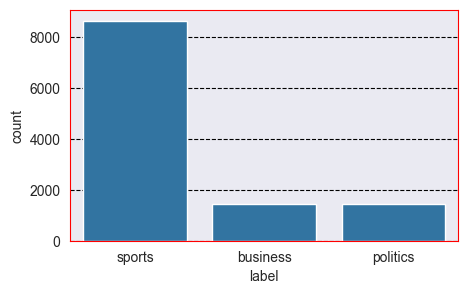

In [3]:
# check available columns
df = data.copy()
print(df.columns)

plt.figure(figsize=(5,3))
sns.countplot(data=df, x='label')

In [4]:
# check random datapoint
idx = np.random.randint(len(df))
print(df.text[idx])

manchester, england — wayne rooney scored twice against bayer leverkusen on tuesday to reach 200 manchester united goals as he enjoys a new lease of life under david moyes who thinks he can become one of the club's greatest predators.the striker's commitment to old trafford had been questioned and he was left out of key games last season under alex ferguson, who also took to playing him in more of a midfield role as robin van persie took the goalscoring glory.rooney is fourth on united's all-time leading scorers' list, behind bobby charlton, denis law (237) and jack rowley (211) and his manager can see him going further."i remember coming in and saying you've got a real chance to be one of the all-time leading goalscorers at this club and i tell you what if he keeps playing like he did tonight he will get there," moyes told a news conference .along with the rousing reception rooney has been getting from the old trafford crowd, despite a turbulent few months, moyes' faith in him seems t

In [5]:
# check num classes in label column -> multi class classification
df.label.value_counts()

label
sports      8639
politics    1451
business    1429
Name: count, dtype: int64

In [6]:
# convert the target variable data type from string to numeric
mapped_classes = df.label.astype('category')
hm_class = dict(enumerate(mapped_classes.cat.categories))
print(hm_class)

df['label'] = df.label.astype('category').cat.codes

{0: 'business', 1: 'politics', 2: 'sports'}


### Preprocessing and vocab generation

In [7]:
# required libraries from nltk for preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize, sent_tokenize

ps = PorterStemmer()
stop = set(stopwords.words('english'))

In [8]:
# common preprocessing function
def clean_text_and_tokenise(doc):
    # remove non-alpha numeric characters and strip off braces
    doc = re.sub(r'[^\w\s]', ' ', doc)
    doc = re.sub(r'[\{\}\[\]\(\)]', '', doc)
    
    # remove stopwords and apply stemming
    tokens = doc.lower().split(" ")
    tokens = [ps.stem(word) for word in tokens if word not in stop and 0 < len(word) < 15]
    return tokens

In [9]:
# helper function to get vocabulary from the corpus of docs
def get_frequency_count_from_docs(doc):
    # apply preprocessing and tokenisation
    tokens = clean_text_and_tokenise(doc)

    # get vocab with frequencies
    vocab_hm = Counter(tokens)
    
    return dict(vocab_hm)

In [10]:
# helper function to get doc frequency
def get_word_frequency_across_doc(df, col, vocab_hm):
    DF = defaultdict(float)
    for doc in tqdm(df[col]):
        # preprocess and get tokens
        tokens = clean_text_and_tokenise(doc)
        for token in set(tokens):
            # check if the word exists in vocab
            if token in vocab_hm:
                DF[token] += 1
    return DF

In [11]:
# get entire raw corpus and lower
corpus = ' '.join(list(df["text"])).lower()

# get vocab from corpus
vocab_hm = get_frequency_count_from_docs(corpus)

# get document frequency map
df_hm = get_word_frequency_across_doc(df, "text", vocab_hm)

100%|████████████████████████████████████| 11519/11519 [00:36<00:00, 319.86it/s]


In [12]:
# check total words in vocabulary and total docs
n_vocab = len(vocab_hm)
n_docs = len(df)
print(n_docs, n_vocab)

11519 45855


In [13]:
# check 10 most and least frequent words for sanity
sorted_vocab = sorted(list(vocab_hm.items()), key = lambda x : -x[1])

print("Most Frequent words in Vocabulary: \n")
pprint(dict(sorted_vocab[:10]))
print("Least Frequent words in Vocabulary: \n")
pprint(dict(sorted_vocab[-10:]))

Most Frequent words in Vocabulary: 

{'first': 24314,
 'game': 34839,
 'one': 22029,
 'play': 23563,
 'said': 59594,
 'season': 20036,
 'team': 18769,
 'time': 18867,
 'two': 22526,
 'year': 29132}
Least Frequent words in Vocabulary: 

{'budson': 1,
 'economix': 1,
 'emerton': 1,
 'fatalist': 1,
 'kerrilyn': 1,
 'nrl': 1,
 'paducah': 1,
 'regionq': 1,
 'shesaidy': 1,
 'taronga': 1}


### Bag of Word Representations

In [14]:
# index vocab hashmap
indexed_vocab_hm = {key: index for index, key in enumerate(vocab_hm.keys())}

In [15]:
# we can create a custom function to create binarised embeddings of a doc using vocabulary
def get_doc_representation(doc, name="binary"):
    # assertion check
    assert name in ["binary", "count", "tfidf"]
    
    # initialise the vector represntation
    vector = np.zeros(n_vocab, dtype=np.int64)

    # get raw doc tokens
    doc_tokens = clean_text_and_tokenise(doc)

    # count of words in doc
    if name != "binary":
        doc_hm = dict(Counter(doc_tokens))
    
    for word in set(doc_tokens):
        if word in indexed_vocab_hm:
            idx = indexed_vocab_hm[word]
            if name == "binary":
                vector[idx] = 1
            elif name == "count":
                vector[idx] = doc_hm[word]
            else:
                # maximum frequency normalisation
                tf = 0.5 + 0.5 * doc_hm[word] / max(doc_hm.values())

                # long idf
                idf = 1 + np.log(n_docs / df_hm[word])

                # tfidf
                vector[idx] = tf * idf
            
    return list(vector)

### Modeling

#### Train-Test-Validation splits

In [16]:
# split training data into train(10%) and validation(10%)
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

def get_data_splits(df, name, use_sparse=True):
    # target
    Y = df["label"]
    df = df.drop(['label'], axis=1)
    
    if name in ["binary", "count"]:
        # apply vectorisation to the documents
        df["bow_vector"] = df['text'].apply(lambda x: get_doc_representation(x, name))
        X = list(df["bow_vector"])
    else:
        # case of tfidf - we want train/test/val to be seperate first
        X = df

    # train test splits
    train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=1-train_ratio, random_state=42)
    val_x, test_x, val_y, test_y = train_test_split(
        val_x, 
        val_y, 
        test_size=validation_ratio/(test_ratio + validation_ratio), 
        random_state=42
    )

    # we apply tfidf seperately for each of the sets 
    if name == "tfidf":
        train_x = list(train_x['text'].apply(lambda x: get_doc_representation(x, name)))
        val_x = list(val_x['text'].apply(lambda x: get_doc_representation(x, name)))
        test_x = list(test_x['text'].apply(lambda x: get_doc_representation(x, name)))
        
    # convert to sparse matrix to speed up training
    if use_sparse:
        train_x = sparse.csr_matrix(train_x)
        test_x = sparse.csr_matrix(test_x)
        val_x = sparse.csr_matrix(val_x)
        
    return train_x, val_x, test_x, train_y, val_y, test_y

#### Training

In [25]:
# logistic regression model using "one-vs-rest" strategy and Grid Search cross validation
# we have a predefined validation dataset
def get_best_LR(X, Y, split_index, param_grid):
    pds = PredefinedSplit(split_index)
    
    # hyperparameter tuning using grid search
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=pds, scoring='accuracy')
    grid_search.fit(X, Y)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params, "Best Accuracy on Validation set", best_score)
    return best_model

In [18]:
def print_metrics(y, y_pred):
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Macro F1 Score:", f1_score(y, y_pred, average='macro'))
    print("Micro F1 Score:", f1_score(y, y_pred, average='micro'))

## 1a. Binarised Document Representation 

In [40]:
# get train/test/validation sets
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(df, "binary", use_sparse=False)

print(
    "train_data_size: {}%, validation_data_size: {}%, test_data_size: {}%".format(
    round(100 * len(train_x)/len(df), 4), 
    round(100 * len(val_x)/len(df), 4), 
    round(100 * len(test_x)/len(df), 4))
)

train_data_size: 79.9983%, validation_data_size: 10.0009%, test_data_size: 10.0009%


In [41]:
# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

# get sparse representations
sparse_X = sparse.csr_matrix(X)
sparse_test_x = sparse.csr_matrix(test_x)

In [42]:
# training and finding the best model
# hyperparameter space
param_grid = {
    'C': [0.001, 0.1, 1, 10, 100], # Regularization strength
    'max_iter': [100, 200],  # Maximum iterations
    'class_weight': [None, 'balanced']  # To handle class imbalance
}

model_binary = get_best_LR(sparse_X, Y, split_index, param_grid)

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100} Best Accuracy on Validation set 0.9817708333333334


#### Inference on test set

In [43]:
# infer using the best model on the test set
y_test_pred = model_binary.predict(sparse_test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9774305555555556
Macro F1 Score: 0.9409356853143893
Micro F1 Score: 0.9774305555555556


In [44]:
# visualisation
# confusion matrix
def plot_confusion_matrix(test_y, y_test_pred):
    cm = confusion_matrix(test_y, y_test_pred)
    
    # create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['business', 'politics', 'sports'],
                yticklabels=['business', 'politics', 'sports'])
    
    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

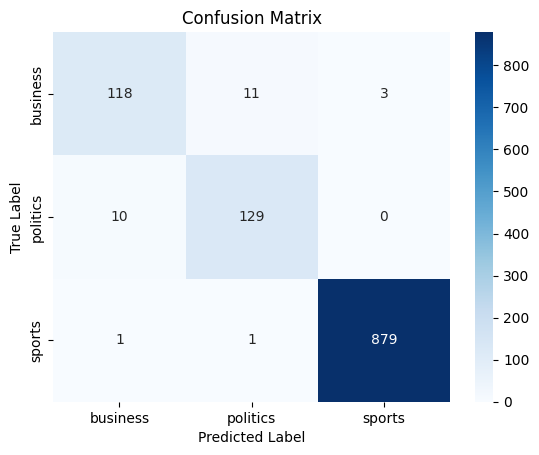

In [45]:
plot_confusion_matrix(test_y, y_test_pred)

## 1b. Count/Frequency based Document Representation 

In [46]:
# get sparse representations
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(df, "count", use_sparse=False)

# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

# get sparse representations
sparse_X = sparse.csr_matrix(X)
sparse_test_x = sparse.csr_matrix(test_x)

In [47]:
# training and finding the best model
model_count = get_best_LR(sparse_X, Y, split_index, param_grid)

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100} Best Accuracy on Validation set 0.9887152777777778


#### Inference on test set

In [48]:
# infer using the best model on the test set
y_test_pred = model_count.predict(sparse_test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9835069444444444
Macro F1 Score: 0.9541470791930237
Micro F1 Score: 0.9835069444444444


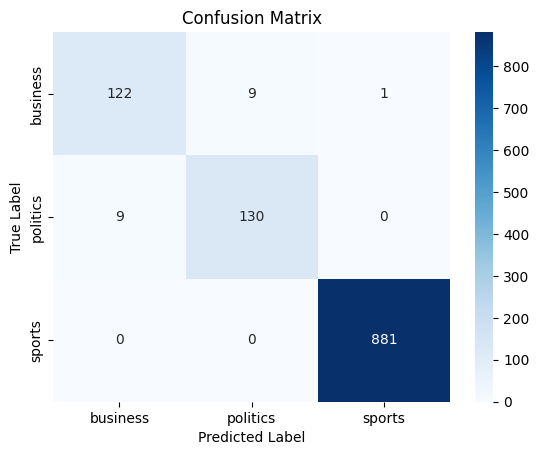

In [49]:
plot_confusion_matrix(test_y, y_test_pred)

## 1c. tf-idf Document Representation 

In [50]:
# get train/test/validation sets
train_x, val_x, test_x, train_y, val_y, test_y = get_data_splits(df, "tfidf", use_sparse=False)

# concat train and val for predefined validation dataset
split_index = [-1]*len(train_x) + [0]*len(val_x)
X = np.concatenate((train_x, val_x), axis=0)
Y = np.concatenate((train_y, val_y), axis=0)

# get sparse representations
sparse_X = sparse.csr_matrix(X)
sparse_test_x = sparse.csr_matrix(test_x)

In [51]:
# training and finding the best model
model_tfidf = get_best_LR(sparse_X, Y, split_index, param_grid)

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 100} Best Accuracy on Validation set 0.984375


#### Inference on test set

In [52]:
# infer using the best model on the test set
y_test_pred = model_tfidf.predict(sparse_test_x)

# calculate metrics on the test set
print_metrics(test_y, y_test_pred)

Accuracy: 0.9782986111111112
Macro F1 Score: 0.9440749977104897
Micro F1 Score: 0.9782986111111112


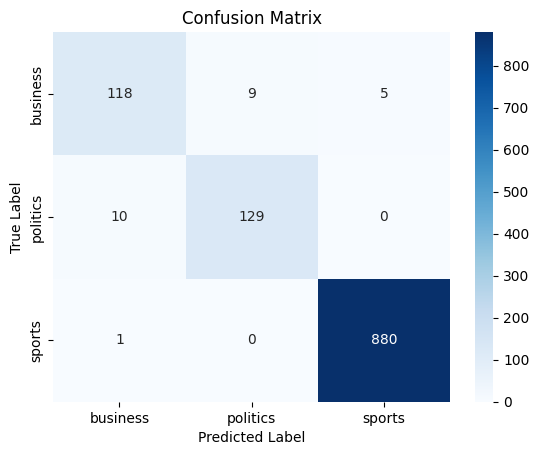

In [53]:
plot_confusion_matrix(test_y, y_test_pred)